In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Hàm ước tính cỡ mẫu cho bài toán so sánh 2 phân phối Gamma

$$\sqrt N\ =\ \frac{\left(Z_{1\ -\ \frac{\alpha}{2}}\ +Z_{1\ -\ \beta}\right)\ \sqrt{\frac{1}{Q_1\kappa_1}+\ \frac{1}{Q_0\kappa_0}}\ \ \ }{log(\mu_0)\ -\ log(\mu_1)}$$

In [19]:
Link_Funcs = {'log':lambda x: np.log(x),
         'id':lambda x: x}

Inverse_Link_Funcs = {'log':lambda x: np.exp(x),
                      'id': lambda x: x}

dMu_dEta_Funcs = {'log': lambda x: x,
                  'id': lambda x: 1.}

def gamma_size(mu0: float, mu1: float, 
               Q0: float, Q1: float, 
               link: str,
               kappa0: float, kappa1: float, power: float, 
               alpha: float, method:int)-> float:
    
    """Function to estimate sample size of 2 samples with Gamma distribution;
    mu0,mu1: Means;
    kappa0, kappa1: shape parameters;
    Q0, Q1: Proportions;
    power: power of the test;
    alpha: type I error rate;
    method: 1 for exact, 2 for approximate;
    Returns: sample size.
    """
    
    # raise error if kappa0 is not defined
    if kappa0 is None:
        raise ValueError("kappa0 is not defined")

    def VarFn(mu, k):
        return mu*mu/k
    
    if link:
        linkFn, InverseLinkFn, dMu_dEtaFn = Link_Funcs[link], Inverse_Link_Funcs[link], dMu_dEta_Funcs[link]
    else:
        raise ValueError("link function is not defined")
        return None
            
    if Q0 + Q1 != 1:
        raise ValueError("Q0 and Q1 should add to 1")
        return None
            
    if alpha < 0 or alpha > 1:
        raise ValueError("alpha should be between 0 and 1")
        return None
            
    if power < 0 or power > 1:
        raise ValueError("power should be between 0 and 1")
        return None
            
    if method != 1 and method != 2:
        raise ValueError("method should be 1 or 2")
        return None
    
    Z_alpha = norm.ppf(1 - alpha/2.)
    Z_beta = norm.ppf(power)
    denom = linkFn(mu0) - linkFn(mu1)
    
    numerator1 = np.sqrt( (VarFn(mu0, kappa0)/((dMu_dEtaFn(mu0))**2))*((1/Q1)+(1/Q0)) )
    
    numerator2 = np.sqrt( ((VarFn(mu0, kappa0)/((dMu_dEtaFn(mu0))**2))/Q0) + 
                          ((VarFn(mu1, kappa1)/((dMu_dEtaFn(mu1))**2))/Q1)
                        )
            
    if method == 2:
        n = (((Z_alpha + Z_beta) * numerator2)/denom)**2
    else:
        n = (((Z_alpha * numerator1) + (Z_beta * numerator2))/denom)**2
            
    return n

# Hàm quy đổi từ trung bình/độ lệch chuẩn sang kappa và theta

In [25]:
def gamma_from_gaussian(mu: float, sigma:float)-> float:
    
    k = mu**2/sigma**2
    theta = mu/k
    
    return k, theta

# Ý nghĩa của kappa và theta quy định kiểu hình của phân phối Gamma

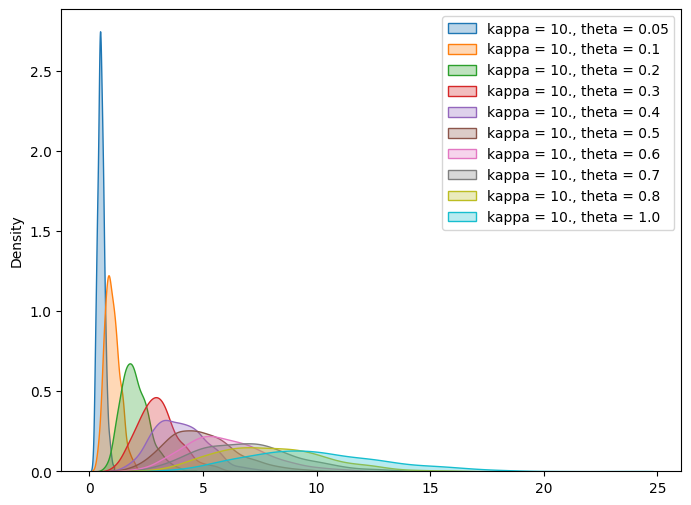

In [221]:
fig = plt.figure(figsize = (8,6))

plt.rc('font', size=10) 

for theta in [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.0]:
    
    samples = np.random.gamma(10., theta, 1000)
    
    sns.kdeplot(pd.Series(samples),
                label = f"kappa = 10., theta = {theta}",
                shade = True, alpha = 0.3,
               clip = [0,samples.max()])

plt.legend()
plt.show()

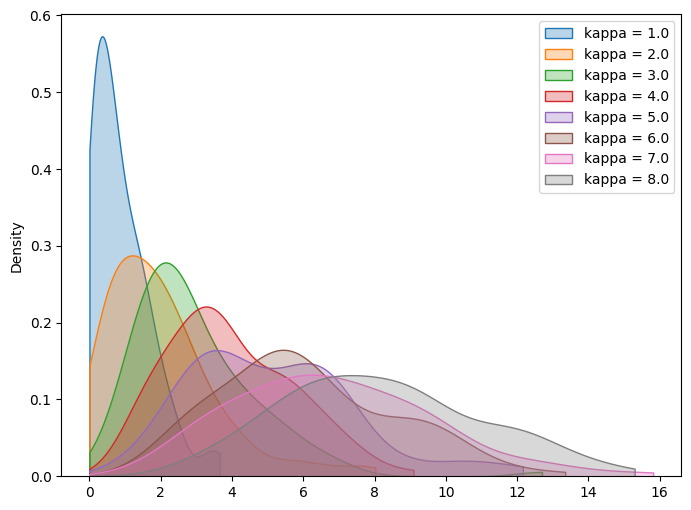

In [244]:
fig = plt.figure(figsize = (8,6))

plt.rc('font', size=10) 

for k in np.linspace(1,8,8):
    
    samples = np.random.gamma(k, 1., 100)
    
    sns.kdeplot(pd.Series(samples),
                label = f"kappa = {k}",
                shade = True, alpha = 0.3,
               clip = [0,samples.max()])

plt.legend()
plt.show()

# Mô phỏng bài toán dựa vào kết quả y văn

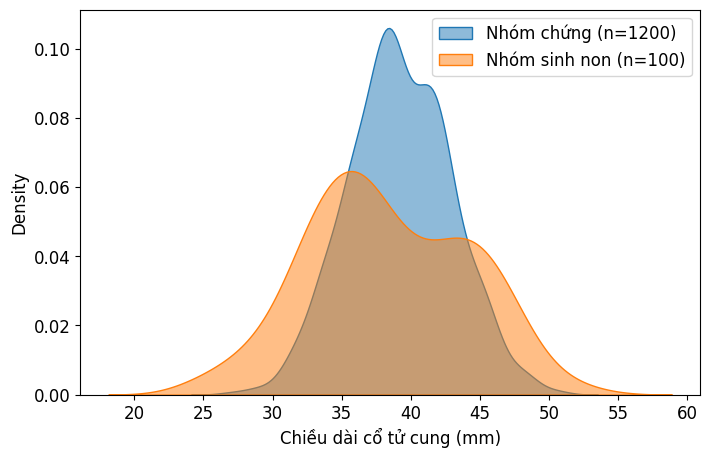

In [248]:
k0,theta0 = gamma_from_gaussian(39.3, 3.8)
k1, theta1 =  gamma_from_gaussian(37.9, 5.7)

x0 = np.random.gamma(shape= k0, scale=theta0, size=1200)
x1 = np.random.gamma(shape= k1, scale=theta1, size=100)

fig = plt.figure(figsize = (8,5))

sns.kdeplot(x0[x0 < 52], shade = 'true', alpha = 0.5, label = 'Nhóm chứng (n=1200)')
sns.kdeplot(x1[x1 < 52], shade = 'true', alpha = 0.5, label = 'Nhóm sinh non (n=100)')
plt.xlabel('Chiều dài cổ tử cung (mm)')
plt.legend()
plt.show()

In [251]:
k0,theta0

(106.95914127423822, 0.36743002544529263)

In [252]:
k1,theta1

(44.21083410280085, 0.8572559366754618)

In [179]:
gamma_size(mu0 = 39.3,
           mu1 = 37.9,
           Q0 = 0.9, 
           Q1 = 0.1, 
           link = "log",
           kappa0 = k0, 
           kappa1 = k1, 
           power = 0.8, 
           alpha = 0.05, 
           method = 1)

823.7234996341663

In [189]:
sim_mu1 = np.linspace(35.,38.,100)

sim_n = []

for mu1 in sim_mu1:
    
    k1,t1 = gamma_from_gaussian(mu1, 7.5)
    
    sim_n.append(gamma_size(mu0 = 39.3, 
                           mu1 = mu1,
                           Q0 = 0.9,
                           Q1 = 0.1,
                           link = 'log',
                           kappa0 = k0,
                           kappa1 = k1,
                           power = 0.8,
                           alpha = 0.05,
                           method = 1))

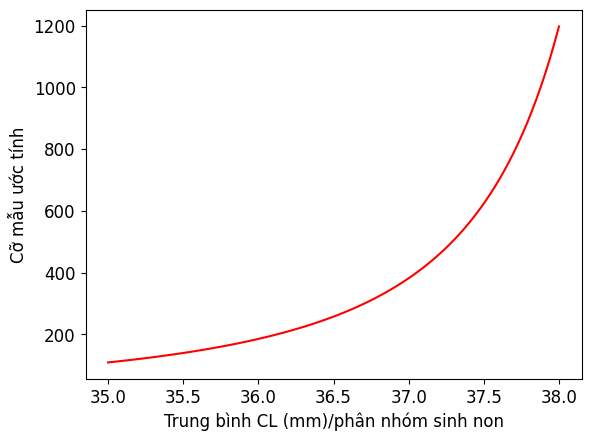

In [190]:
plt.rc('font', size=12) 
fig = plt.figure()
plt.plot(sim_mu1, sim_n, 'r-')
plt.xlabel('Trung bình CL (mm)/phân nhóm sinh non')
plt.ylabel('Cỡ mẫu ước tính')
plt.show()

In [246]:
sim_s1 = np.linspace(2.,8., 100)

sim_n = []

for s1 in sim_s1:
    
    k1,t1 = gamma_from_gaussian(mu = 37.9, sigma = s1)
    
    sim_n.append(gamma_size(mu0 = 39.3, 
                           mu1 = 37.9,
                           Q0 = 0.9,
                           Q1 = 0.1,
                           link = 'log',
                           kappa0 = k0,
                           kappa1 = k1,
                           power = 0.8,
                           alpha = 0.05,
                           method = 1))

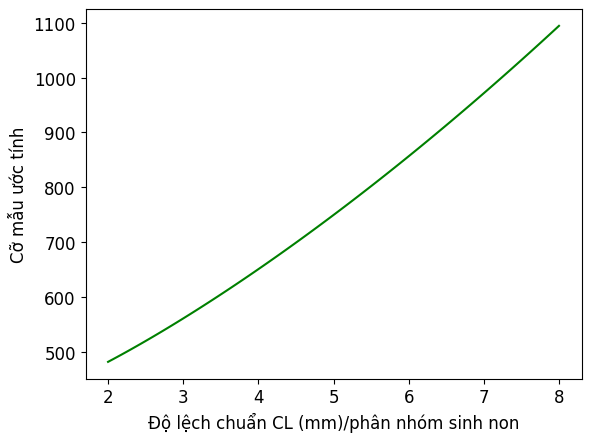

In [247]:
plt.rc('font', size=12) 
fig = plt.figure()
plt.plot(sim_s1, sim_n, 'g-')
plt.xlabel('Độ lệch chuẩn CL (mm)/phân nhóm sinh non')
plt.ylabel('Cỡ mẫu ước tính')
plt.show()